# Differentiate weeds from crop seedlings using a convolutional neural network (CNN)

The goal of the project is to correctly identify the weed type from a variety of weed and crop RGB images using a relatively big dataset (~2GB).

Created on Sun Jan 12 12:33:49 2020

@author: neal gilmore

## What is the objective of the machine learning model?

We aim to maximise the accuracy, i.e., the correct classification of the different weed varieties.

## Table of Contents<a id='0.0'></a>

#### [STEP 1: Environment Preparation](#1.0)
1.1 [Import required libraries](#1.1)  
1.2 [Prepare for reproducability](#1.2)  

#### [STEP 2: Data Preparation](#2.0)
2.1 [Import data](#2.1)  
2.2 [Prepare dataframe of image directories and classifications](#2.2)  
2.3 [Summary statistics](#2.3) 

#### [STEP 3: Data Analysis](#3.0)
3.1 [Visualize a few images](#3.1)  

#### [STEP 4: Feature Engineering](#4.0)
4.1 [Separate data into training and test sets](#4.1)  
4.2 [Assess split of classes](#4.2)  
4.3 [Label encode target for multiclass classification](#4.3)  
4.4 [Standardize image sizes](#4.4)  
4.5 [Reshape the dataset](#4.5)  

#### [STEP 5: Model Building](#5.0)
5.1 [Define the convolutional neural network](#5.1)  
5.2 [Complile the model](#5.2)  
5.3 [Train the model](#5.3)  

#### [STEP 6: Model Evaluation](#6.0)
6.1 [Visualize training results](#6.1)  
6.2 [Make a prediction](#6.2)  
6.3 [Create confusion matrix](#6.3)  
6.4 [Transform numbers back to classes](#6.4)  
6.5 [confusion matrix](#6.5)  
6.6 [Accuracy score and classification report of test dataset](#6.6)  

## STEP 1: Environment Preparation<a id='1.0'></a> [(Top)](#0.0)

### 1.1 Import required libraries<a id='1.1'></a> [(Top)](#0.0)

In [1]:
# System libraries
import os
import sys
import time
import warnings
from glob import glob

# Basic Python libraries
import numpy as np
import pandas as pd
import random
from math import sqrt
import matplotlib.style
import matplotlib.pyplot as plt
import seaborn as sns; #sns.set(style="white", color_codes=True)
import missingno as msno # Provides a library of data missingness functions 

# Images library
import cv2

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Tensorflow Keras libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.models import Model
#from tensorflow.keras import backend as K
import keras.backend.tensorflow_backend as K
from keras.utils import np_utils

# ### Turn off Depreciation and Future warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

if not sys.warnoptions:
    warnings.simplefilter('ignore')

#%matplotlib inline

pd.set_option('precision', 3) # set the precision of numerical representation
pd.set_option('expand_frame_repr', True)
pd.set_option('display.max_columns', None) # to display all the columns of the dataframe in the notebook

# Set the plotting style
plt.style.use('default')

print('>> Required libraries imported')

>> Required libraries imported


Using TensorFlow backend.


### 1.2 Prepare for reproducability<a id="1.2"></a>[(Top)](#0.0)

In [2]:
# Set random seed to maintain reproducability
random_state = np.random.seed(42)
random.seed(random_state)
os.environ['PYTHONHASHSEED']=str(random_state) 
#tf.random.set_seed(random_state) # set tensorflow psuedo-random generator to fixed value

# Configure a new tensorflow session
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#K.set_session(sess)

## STEP 2: Data Preparation<a id='2.0'></a> [(Top)](#0.0)

### 2.1 Import data<a id='2.1'></a> [(Top)](#0.0)

In [3]:
# Import the dataset

# here are all our images
DATA_FOLDER = '../data/raw/v2-plant-seedlings-dataset'

# each weed class is in a dedicated folder
os.listdir(DATA_FOLDER)

['Cleavers',
 'Sugar beet',
 'Common Chickweed',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Fat Hen',
 'Common wheat',
 'Black-grass',
 'nonsegmentedv2',
 'Small-flowered Cranesbill',
 'Charlock',
 'Maize']

### 2.2 Prepare dataframe of image directories and classifications<a id='2.2'></a> [(Top)](#0.0)

In [4]:
# Walk over the directory structure to understand how 
# the images are stored

for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        print(image_path)

../data/raw/v2-plant-seedlings-dataset/Cleavers/348.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/176.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/88.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/162.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/189.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/77.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/63.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/228.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/200.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/214.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/215.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/201.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/229.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/62.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/188.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/76.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/163.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/177.p

../data/raw/v2-plant-seedlings-dataset/Common Chickweed/634.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/152.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/146.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/620.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/608.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/90.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/84.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/191.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/185.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/53.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/1.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/47.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/224.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/542.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/556.png
../data/raw/v2-plant-seedlings-dataset/Common 

../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/275.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/513.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/249.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/16.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/117.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/103.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/498.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/473.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/315.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/301.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/467.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/329.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/463.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/305.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/311.png
../data/raw/v2-plant-seedl

../data/raw/v2-plant-seedlings-dataset/Fat Hen/27.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/33.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/536.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/250.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/244.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/522.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/278.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/293.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/287.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/286.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/292.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/279.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/245.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/523.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/537.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/251.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/32.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/26.png
../data/raw/v2

../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/270.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/13.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/112.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/106.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/489.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/338.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/310.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/476.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/462.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/304.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/474.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/312.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/306.png
../data/raw/v2-plant-seedlings-dataset/Small-flowere

../data/raw/v2-plant-seedlings-dataset/Maize/80.png
../data/raw/v2-plant-seedlings-dataset/Maize/94.png
../data/raw/v2-plant-seedlings-dataset/Maize/82.png
../data/raw/v2-plant-seedlings-dataset/Maize/96.png
../data/raw/v2-plant-seedlings-dataset/Maize/168.png
../data/raw/v2-plant-seedlings-dataset/Maize/140.png
../data/raw/v2-plant-seedlings-dataset/Maize/154.png
../data/raw/v2-plant-seedlings-dataset/Maize/41.png
../data/raw/v2-plant-seedlings-dataset/Maize/55.png
../data/raw/v2-plant-seedlings-dataset/Maize/7.png
../data/raw/v2-plant-seedlings-dataset/Maize/183.png
../data/raw/v2-plant-seedlings-dataset/Maize/69.png
../data/raw/v2-plant-seedlings-dataset/Maize/197.png
../data/raw/v2-plant-seedlings-dataset/Maize/236.png
../data/raw/v2-plant-seedlings-dataset/Maize/222.png
../data/raw/v2-plant-seedlings-dataset/Maize/223.png
../data/raw/v2-plant-seedlings-dataset/Maize/237.png
../data/raw/v2-plant-seedlings-dataset/Maize/68.png
../data/raw/v2-plant-seedlings-dataset/Maize/196.png
../

In [5]:
# Create a dataframe that stores the paths to the images in one column
# and the class of the weed (the target) in the next column

images_df = []

# navigate within each folder
for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    
    # collect every image path
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        
        tmp = pd.DataFrame([image_path, class_folder_name]).T
        images_df.append(tmp)

# concatenate the final df
images_df = pd.concat(images_df, axis=0, ignore_index=True)
images_df.columns = ['image', 'target']
images_df.head(10)

image    target
0  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
1  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
2  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
3  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
4  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
5  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
6  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
7  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
8  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
9  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers

### 2.3 Summary statistics<a id='2.3'></a> [(Top)](#0.0)

In [6]:
# Identify how many images per class
images_df['target'].value_counts()

Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherds Purse              274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

In [7]:
# Isolate a path for demo
# we want to load the image in this path later

images_df.loc[0, 'image']

'../data/raw/v2-plant-seedlings-dataset/Cleavers/348.png'

## STEP 3: Data Analysis<a id='3.0'></a> [(Top)](#0.0)

### 3.1 Visualize a few images<a id='3.1'></a> [(Top)](#0.0)

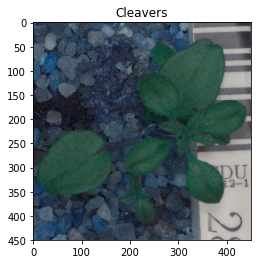

In [8]:
# Visualise a few images
def plot_single_image(df, image_number):
    im = cv2.imread(df.loc[image_number, 'image'])
    plt.title(df.loc[image_number, 'target'])
    plt.imshow(im)
    
plot_single_image(images_df, 0)

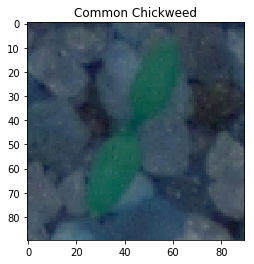

In [9]:
plot_single_image(images_df, 1000)

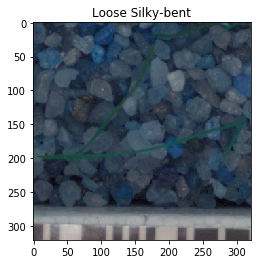

In [10]:
plot_single_image(images_df, 2000)

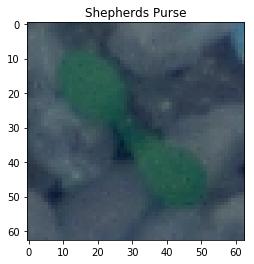

In [11]:
plot_single_image(images_df, 3000)

In [12]:
# Plot a bunch of our images together to get a 
# better feeling of how the images look
def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3
    
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(16, 16))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label ]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])          
            axs[i, j].imshow(im)
            n += 1

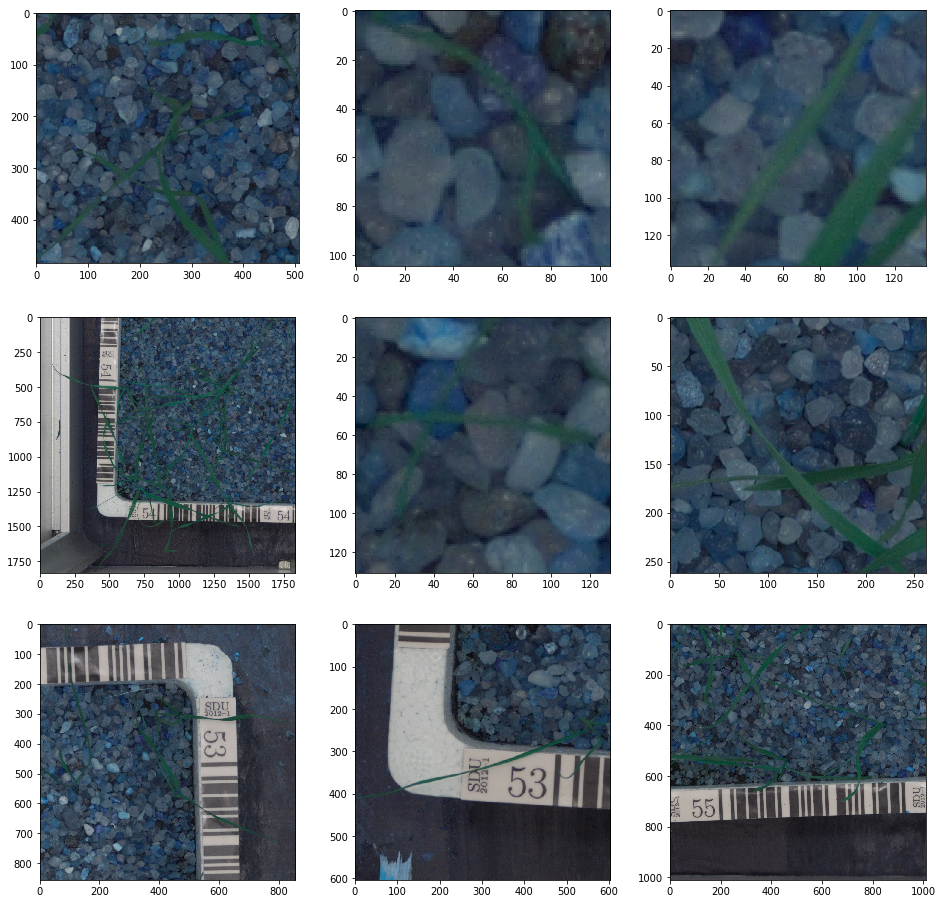

In [13]:
plot_for_class(images_df, 'Loose Silky-bent')

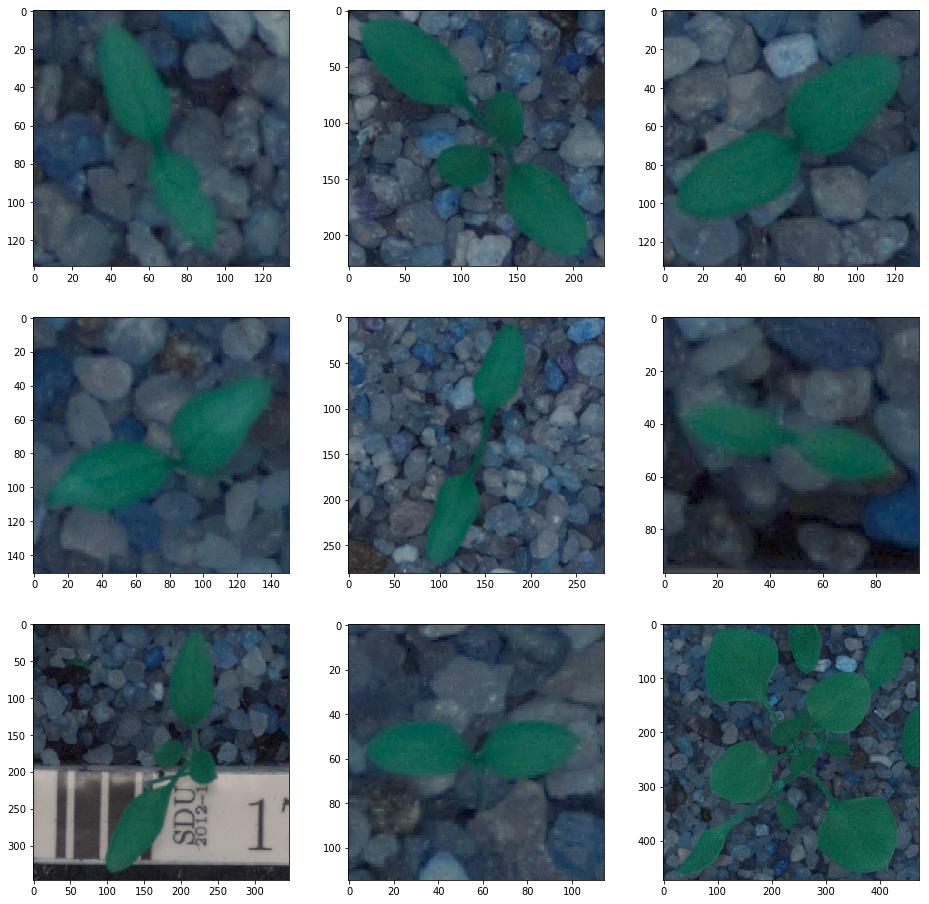

In [14]:
plot_for_class(images_df, 'Common Chickweed')

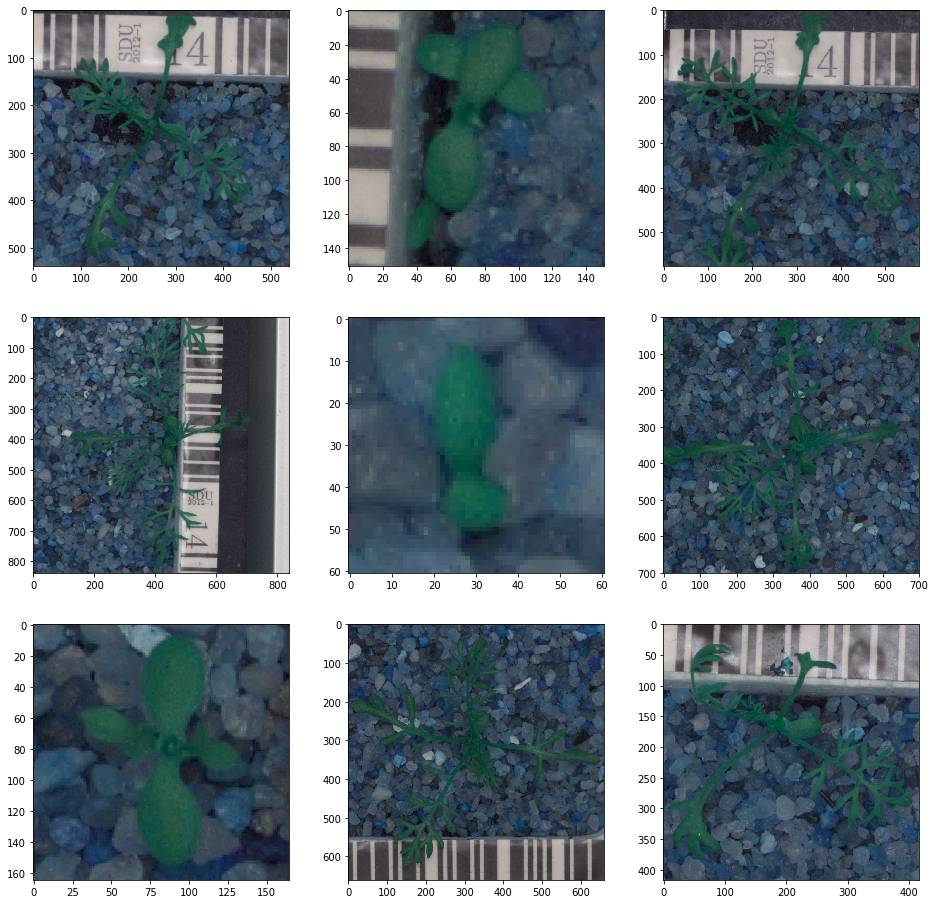

In [15]:
plot_for_class(images_df, 'Scentless Mayweed')

## STEP 4: Feature Engineering<a id='4.0'></a> [(Top)](#0.0)

### 4.1 Separate data into training and test sets<a id='4.1'></a> [(Top)](#0.0)

In [16]:
# Separate the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images_df['image'], 
                                                    images_df['target'], 
                                                    test_size=0.20, 
                                                    random_state=random_state)

print(X_train.shape)
print(X_test.shape)

(4431,)
(1108,)


In [17]:
# Reset the index as later we iterate over the data by rownumber
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_train.head()

0    ../data/raw/v2-plant-seedlings-dataset/Small-f...
1    ../data/raw/v2-plant-seedlings-dataset/Scentle...
2    ../data/raw/v2-plant-seedlings-dataset/Scentle...
3    ../data/raw/v2-plant-seedlings-dataset/Charloc...
4    ../data/raw/v2-plant-seedlings-dataset/Common ...
Name: image, dtype: object

In [18]:
# Likewise, reset index of the target
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### 4.2 Assess split of classes<a id='4.2'></a> [(Top)](#0.0)

In [19]:
# Assess percentage of images within each class
y_train.value_counts() / len(y_train)

Loose Silky-bent             0.139
Common Chickweed             0.130
Scentless Mayweed            0.110
Small-flowered Cranesbill    0.103
Fat Hen                      0.100
Sugar beet                   0.082
Charlock                     0.080
Cleavers                     0.058
Black-grass                  0.056
Shepherds Purse              0.051
Common wheat                 0.047
Maize                        0.045
Name: target, dtype: float64

In [20]:
# Should be the same in the test set
y_test.value_counts() / len(y_test)

Loose Silky-bent             0.131
Common Chickweed             0.125
Scentless Mayweed            0.109
Small-flowered Cranesbill    0.106
Sugar beet                   0.090
Charlock                     0.089
Fat Hen                      0.087
Cleavers                     0.071
Black-grass                  0.053
Maize                        0.053
Shepherds Purse              0.042
Common wheat                 0.042
Name: target, dtype: float64

### 4.3 Label encode target for multiclass classification<a id='4.3'></a> [(Top)](#0.0)

In [21]:
# Label encode target for multiclass classification
encoder = LabelEncoder()
encoder.fit(y_train)

train_y = np_utils.to_categorical(encoder.transform(y_train))
test_y = np_utils.to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 4.4 Standardize image sizes<a id='4.4'></a> [(Top)](#0.0)

In [22]:
# The source images are all different sizes
# For neural networks however, we need images in the same size
# Therefore, we will standardize image sizes
IMAGE_SIZE = 150

def im_resize(df, n):
    im = cv2.imread(df[n])
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    return im

In [23]:
tmp = im_resize(X_train, 7)
tmp.shape

(150, 150, 3)

### 4.5 Reshape the dataset<a id='4.5'></a> [(Top)](#0.0)

In [24]:
# The shape of the datasets needs to be (n1, n2, n3, n4)
# where n1 is the number of observations,
# n2 and n3 are image width and length
# and n4 indicates that it is a color image
# with 3 planes per image (RGB)
def create_dataset(df, image_size):
    # functions creates dataset as required for cnn
    tmp = np.zeros((len(df), image_size, image_size, 3), dtype='float32')

    for n in range(0, len(df)):
        im = im_resize(df, n)
        tmp[n] = im
  
    print('Dataset Images shape: {} size: {:,}'.format(tmp.shape, tmp.size))
    return tmp

In [25]:
# Reshape the training dataset
x_train = create_dataset(X_train, IMAGE_SIZE)

Dataset Images shape: (4431, 150, 150, 3) size: 299,092,500


In [26]:
# Reshape the test dataset
x_test = create_dataset(X_test, IMAGE_SIZE)

Dataset Images shape: (1108, 150, 150, 3) size: 74,790,000


In [27]:
# number of different classes
print('Number of different classes:', len(y_train.unique()))

Number of different classes: 12


## STEP 5: Model Building<a id='5.0'></a> [(Top)](#0.0)

### 5.1 Define the convolutional neural network<a id='5.1'></a> [(Top)](#0.0)

In [28]:
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
#model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
#model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
#model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 64)        0

### 5.2 Compile the model<a id='5.2'></a> [(Top)](#0.0)

In [29]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

### 5.3 Train the model<a id='5.3'></a> [(Top)](#0.0)

In [30]:
# Set model parameters
batch_size = 10
epochs = 8

In [31]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=1, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(x=x_train, 
                    y=train_y,
                    batch_size=batch_size, 
                    validation_split=10,
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks_list)

Train on 4431 samples
Epoch 1/8

Epoch 00001: accuracy improved from -inf to 0.89831, saving model to model.h5
4431/4431 - 158s - loss: 0.7157 - accuracy: 0.8983
Epoch 2/8

Epoch 00002: accuracy improved from 0.89831 to 0.92505, saving model to model.h5
4431/4431 - 153s - loss: 0.2050 - accuracy: 0.9251
Epoch 3/8

Epoch 00003: accuracy improved from 0.92505 to 0.93940, saving model to model.h5
4431/4431 - 158s - loss: 0.1558 - accuracy: 0.9394
Epoch 4/8

Epoch 00004: accuracy improved from 0.93940 to 0.95221, saving model to model.h5
4431/4431 - 151s - loss: 0.1233 - accuracy: 0.9522
Epoch 5/8

Epoch 00005: accuracy improved from 0.95221 to 0.96009, saving model to model.h5
4431/4431 - 157s - loss: 0.1046 - accuracy: 0.9601
Epoch 6/8

Epoch 00006: accuracy improved from 0.96009 to 0.96957, saving model to model.h5
4431/4431 - 155s - loss: 0.0832 - accuracy: 0.9696
Epoch 7/8

Epoch 00007: accuracy improved from 0.96957 to 0.97258, saving model to model.h5
4431/4431 - 158s - loss: 0.0735

## STEP 6: Model Evaluation<a id='6.0'></a> [(Top)](#0.0)

### 6.1 Visualize training results<a id='6.1'></a> [(Top)](#0.0)

<Figure size 432x288 with 0 Axes>

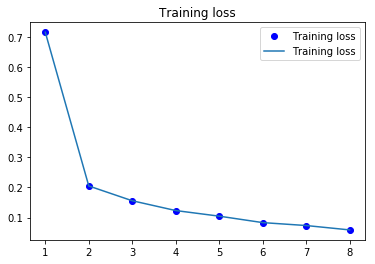

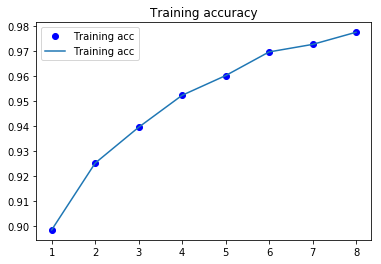

<Figure size 432x288 with 0 Axes>

In [32]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, acc, label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

### 6.2 Make a prediction<a id='6.2'></a> [(Top)](#0.0)

In [33]:
# Make a prediction
predictions = model.predict_classes(x_test, verbose=1)

1108/1108 [==============================] - 10s 9ms/sample


In [34]:
# Inspect predictions
predictions

array([ 0, 11, 10, ..., 10,  5,  2])

In [35]:
# Transform target
encoder.transform(y_test)

array([ 0,  8, 10, ...,  3,  5,  2])

### 6.3 Create confusion matrix<a id='6.3'></a> [(Top)](#0.0)

In [36]:
# Create confusion matrix
cnf_matrix = confusion_matrix(encoder.transform(y_test), predictions)

### 6.4 Transform numbers back to classes<a id='6.4'></a> [(Top)](#0.0)

In [37]:
# Create a dict to map back the numbers to the classes
tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis=1)
tmp.columns = ['class_name', 'class_number']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = pd.Series(tmp.class_name.values,index=tmp.class_number).to_dict()
tmp

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

### 6.5 Plot confusion matrix<a id='6.5'></a> [(Top)](#0.0)

In [38]:
# these we will display in the below matrix
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

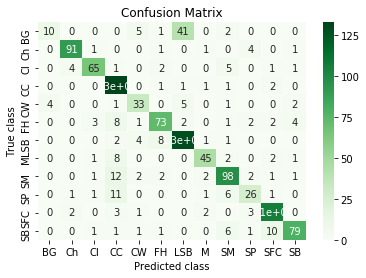

In [39]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.show();

### 6.6 Accuracy score and classification report of test dataset<a id='6.6'></a> [(Top)](#0.0)

In [40]:
print(accuracy_score(encoder.transform(y_test), predictions, normalize=True, sample_weight=None))

0.8023465703971119


In [41]:
print(classification_report(encoder.transform(y_test), predictions))

             precision    recall  f1-score   support

          0       0.71      0.17      0.27        59
          1       0.93      0.92      0.92        99
          2       0.89      0.82      0.86        79
          3       0.74      0.96      0.83       139
          4       0.70      0.72      0.71        46
          5       0.82      0.76      0.79        96
          6       0.72      0.89      0.80       145
          7       0.85      0.76      0.80        59
          8       0.80      0.81      0.80       121
          9       0.68      0.55      0.61        47
         10       0.85      0.91      0.88       118
         11       0.89      0.79      0.84       100

avg / total       0.80      0.80      0.79      1108

